# Setup

In [432]:
import json
import os
from io import StringIO
import sys

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import roc_curve, recall_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

from utils import read_csv_non_utf

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

# Reading and exploring data

In [3]:
# Reading in as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)
ben_lop2019.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


In [4]:
# Checking basic info
num_species = len(ben_lop2019['Species'].unique())
print(f'{num_species} species')

print(f'{len(ben_lop2019)} effect sizes')

num_studies = len(ben_lop2019['Study'].unique())
print(f'{num_studies} studies')

296 species
3281 effect sizes
163 studies


## Exploring taxonomic representation

In [ ]:
order_counts = ben_lop2019['Order'].value_counts()

plt.barh(order_counts.index, order_counts.values)
plt.title('Order Representation (w/in Mammalia)', weight = 'bold');

In [ ]:
fam_counts = ben_lop2019['Family'].value_counts()

plt.figure(figsize = (6, 12))

plt.barh(fam_counts.index, fam_counts.values)
plt.title('Family Representation (w/in Mammalia)', weight = 'bold')

plt.margins(y = 0.01);

In [ ]:
species_counts = ben_lop2019['Species'].value_counts()
species_cumsum = species_counts.to_numpy().cumsum()

plt.plot(species_cumsum)

plt.ylabel('Cumulative Count', weight = 'bold')
plt.xlabel('Number of Species', weight = 'bold');

## Exploring spatial representation

In [ ]:
region_counts = ben_lop2019['Region'].value_counts()

plt.barh(region_counts.index, region_counts)
plt.xlabel('Number of Effect Sizes', weight = 'bold');

In [ ]:
# Plotting distribution of effect sizes across countries
country_counts = ben_lop2019['Country'].value_counts().to_frame().reset_index()

fig = px.choropleth(country_counts, 
                    locations = 'Country',
                    locationmode = 'country names',
                    color = 'count', 
                    hover_name = 'Country', 
                    color_continuous_scale = px.colors.sequential.Plasma, 
                    width = 1000,
                    height = 500)
fig.show()

In [ ]:
# Plotting study locations as a scatterplot
fig = px.scatter_geo(ben_lop2019, 
                     lat = 'Y',
                     lon = 'X',
                     hover_name = 'Reference',
                     opacity = 0.1,
                     width = 1000,
                     height = 500)
fig.show()

## Inspecting response variable

In [5]:
# Checking number of extirpation events in the dataset
num_non_extirp = (ben_lop2019['ratio'] != 0).sum()
num_extirp = len(ben_lop2019) - num_non_extirp

print(f'{num_extirp} extirpation events ({round(num_extirp / len(ben_lop2019) * 100, 2)}%), {num_non_extirp} non-extirpation events ({round(num_non_extirp / len(ben_lop2019) * 100, 2)}%)')

408 extirpation events (12.44%), 2873 non-extirpation events (87.56%)


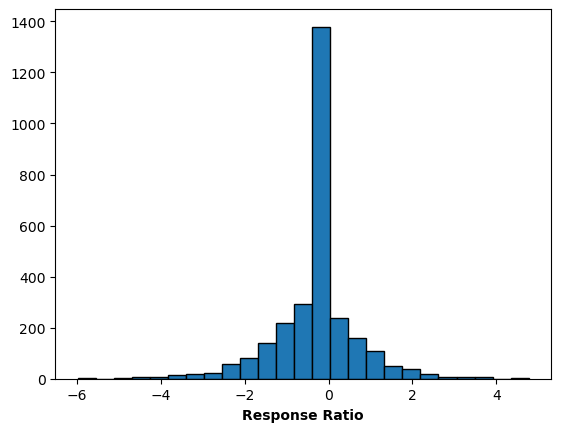

In [6]:
# Plotting a histogram of response ratio
plt.hist(ben_lop2019[ben_lop2019['ratio'] != 0]['RR'], bins = 25, edgecolor = 'black')

plt.xlabel('Response Ratio', weight = 'bold');

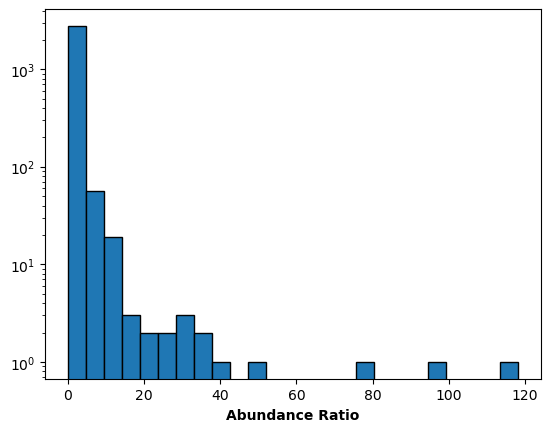

In [7]:
# Plotting a histogram of actual abundance ratios (hunted to unhunted)
plt.hist(ben_lop2019[ben_lop2019['ratio'] != 0]['ratio'], bins = 25, edgecolor = 'black')

plt.yscale('log')
plt.xlabel('Abundance Ratio', weight = 'bold');

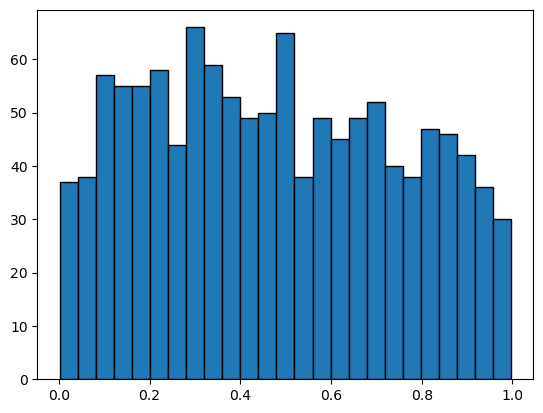

In [201]:
# Plotting thhe distribution of abundance ratios for values between 0 and 1
plt.hist(ben_lop2019[(ben_lop2019['ratio'] < 1) & (ben_lop2019['ratio'] > 0)]['ratio'], bins = 25, edgecolor = 'black');

# Fitting a hurdle model

- Currently, I'm ignoring the random effects component of the model. I think `statsmodels` implements [mixed linear models](https://www.statsmodels.org/stable/mixed_linear.html).
   - [This site](https://geoffruddock.com/building-a-hurdle-regression-estimator-in-scikit-learn/) may be helpful in building an `sklearn` type estimator to fit into a cross-validation procedure.
- Just fitting using the results of their model selection procedure, i.e., only the input variables that they found to be the most important using a [BIC criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion).

Things to try:
- [x] Implement cross-validation
- [x] Model evaluation using the three defaunation categories and using their metrics
- [ ] Figure out what sensitivity and specificity mean in this context...
- [ ] Try to match their model as closely as possible (mixed effect model, REML for optimization)
   - May need to move over to statsmodels to do this...
- [ ] Try to recover threshold tuning approach for just the classifier following "Combined effects of land use and hunting on distributions of tropical mammals" ([code](https://lifesciences.datastations.nl/file.xhtml?fileId=6882&version=2.0&toolType=PREVIEW))
   - May just be helpful to try running the R code from scratch to see if you get the same thing... 

## Helper functions & classes

### Old helper functions

In [344]:
def OLD_get_zero_nonzero_datasets(ben_lop_data, pred = True, include_indicators = False, standardize = False):   
    # Grabbing needed predictors for each model
    nonzero_columns = ['BM', 'DistKm', 'PopDens']
    zero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'Reserve']
    indicator_columns = ['Country', 'Species', 'Study']
    
    X_nonzero = ben_lop_data[nonzero_columns].copy(deep = True)
    X_zero = ben_lop_data[zero_columns].copy(deep = True)
    
    # Adding cross terms, indicators, and quadratic terms
    X_nonzero['DistKm^2'] = X_nonzero['DistKm'] ** 2
    X_nonzero['PopDens^2'] = X_nonzero['PopDens'] ** 2
    X_nonzero['BMxDistKm'] = X_nonzero['BM'] * X_nonzero['DistKm']
    
    X_zero['DistKm^2'] = X_zero['DistKm'] ** 2
    X_zero['Reserve'] = (X_zero['Reserve'] == 'Yes').astype(int)

    # Optionally standardizing continuous predictors
    if standardize:
        X_nonzero_scaled = StandardScaler().fit_transform(X_nonzero)
        X_nonzero = pd.DataFrame(X_nonzero_scaled, index = X_nonzero.index, columns = X_nonzero.columns)

        reserve = X_zero['Reserve'].copy(deep = True)
        X_zero_scaled = StandardScaler().fit_transform(X_zero)
        X_zero = pd.DataFrame(X_zero_scaled, index = X_zero.index, columns = X_zero.columns)
        X_zero['Reserve'] = reserve

    # Optionally adding indicators for different groups present in data
    if include_indicators:
        X_nonzero = pd.concat((X_nonzero, ben_lop_data[indicator_columns].copy(deep = True)), axis = 1)
        X_nonzero = pd.get_dummies(X_nonzero, dtype = float, drop_first = True, columns = indicator_columns)

        X_zero = pd.concat((X_zero, ben_lop_data[indicator_columns].copy(deep = True)), axis = 1)
        X_zero = pd.get_dummies(X_zero, dtype = float, drop_first = True, columns = indicator_columns)
    
    # Extracting the inputs/outputs for each of the models in the case where we have labels
    if not pred:
        ratio = ben_lop_data['ratio'].values
        nonzero_mask = (ratio != 0)
        
        X_nonzero = X_nonzero[nonzero_mask].copy(deep = True)
        
        y_zero = (ratio == 0).astype(int) # the positive class corresponds to local extirpation!
        y_nonzero = np.log(ratio[nonzero_mask].copy())

        return X_zero, y_zero, X_nonzero, y_nonzero

    return X_zero, X_nonzero

In [341]:
def CUSTOM_cross_validate_predict(dataset, model, num_folds = 5):
    folds = np.array(np.split(dataset, num_folds, axis = 0)) # split rows into k folds

    y_pred = []
    for i, fold in enumerate(folds):
        train = np.concatenate(np.delete(folds, i, axis = 0), axis = 0) # grab all but the test fold for training
        test = folds[i] # get test fold
 
        model.fit(train)
        y_pred.extend(model.predict(test))

### Current helper functions

In [404]:
def get_zero_nonzero_datasets(pp_data, pred = True):   
    # Grabbing needed predictors for each model
    indicator_columns = ['Country', 'Species', 'Study']
    nonzero_columns = ['BM', 'DistKm', 'DistKm^2', 'PopDens', 'PopDens^2', 'BMxDistKm']
    zero_columns = ['BM', 'DistKm', 'DistKm^2', 'PopDens', 'Stunting', 'Reserve']
    
    X_nonzero = pp_data[nonzero_columns].copy(deep = True)
    X_zero = pp_data[zero_columns].copy(deep = True)

    for col in indicator_columns:
        X_nonzero = pd.concat((X_nonzero, pp_data.filter(like = col)), axis = 1)
        X_zero = pd.concat((X_zero, pp_data.filter(like = col)), axis = 1)
    
    # Extracting the inputs/outputs for each of the models in the case where we have labels
    if not pred:
        ratio = pp_data['ratio'].values
        nonzero_mask = (ratio != 0)
        
        X_nonzero = X_nonzero[nonzero_mask].copy(deep = True)
        
        y_zero = (ratio == 0).astype(int) # the positive class corresponds to local extirpation!
        y_nonzero = np.log(ratio[nonzero_mask].copy())

        return X_zero, y_zero, X_nonzero, y_nonzero

    return X_zero, X_nonzero

In [405]:
def preprocess_data(ben_lop_data, include_indicators = False, standardize = False):   
    # Defining the variables needed
    indicator_columns = ['Country', 'Species', 'Study']
    continuous_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'Reserve']
    response_column = 'ratio'
    
    # Grabbing just the continuous variables
    pp_data = ben_lop_data[continuous_columns].copy(deep = True)
    
    # Adding cross terms, indicators, and quadratic terms
    pp_data['DistKm^2'] = pp_data['DistKm'] ** 2
    pp_data['PopDens^2'] = pp_data['PopDens'] ** 2
    pp_data['BMxDistKm'] = pp_data['BM'] * pp_data['DistKm']
    pp_data['Reserve'] = (pp_data['Reserve'] == 'Yes').astype(int)

    # Optionally standardizing continuous predictors
    if standardize:
        reserve = pp_data['Reserve'].copy(deep = True)
        pp_data_scaled = StandardScaler().fit_transform(pp_data)
        pp_data = pd.DataFrame(pp_data_scaled, index = pp_data.index, columns = pp_data.columns)
        pp_data['Reserve'] = reserve

    # Optionally adding indicators for different groups present in data
    if include_indicators:
        pp_data = pd.concat((pp_data, ben_lop_data[indicator_columns].copy(deep = True)), axis = 1)
        pp_data = pd.get_dummies(pp_data, dtype = float, drop_first = True, columns = indicator_columns)

    # Add back in the response variable
    pp_data[response_column] = ben_lop_data[response_column]
    
    return pp_data

In [434]:
class HurdleModelEstimator(RegressorMixin, BaseEstimator):
    def __init__(self, zero_model, nonzero_model, prob_thresh = 0.5):
        self.zero_model = zero_model
        self.nonzero_model = nonzero_model
        self.prob_thresh = prob_thresh

    def fit(self, pp_data):
        X_zero, y_zero, X_nonzero, y_nonzero = get_zero_nonzero_datasets(pp_data, pred = False)

        self.nonzero_model.fit(X_nonzero, y_nonzero)
        self.zero_model.fit(X_zero, y_zero)

        return self

    def predict(self, pp_data):
        X_zero, X_nonzero = get_zero_nonzero_datasets(pp_data, pred = True)

        y_pred_zero = self.zero_model.predict_proba(X_zero)[ : , 1] >= self.prob_thresh # hard classification, 1 = local extirpation
        y_pred_nonzero = self.nonzero_model.predict(X_nonzero)

        y_pred = (~y_pred_zero).astype(int) * y_pred_nonzero # if y_pred_zero >= prob_thresh, this is a local extirpation so our prediction should be zero

        return y_pred

In [407]:
def ratios_to_DI_cats(ratios, categories = None):
    DI = 1 - ratios # go from abundance ratio to percentage lost due to hunting
    DI_categories = DI.copy()
    
    DI_categories[0.1 >= DI] = 0
    DI_categories[(0.7 > DI) & (DI > 0.1)] = 1
    DI_categories[DI >= 0.7] = 2

    if categories is not None:
        DI_categories = np.array([categories[cat] for cat in DI_categories])

    return DI_categories

## Fitting the model using `sklearn`

Currently, this is a just a fixed effects model, since mixed effects models don't seem to have great support in Python...

In [490]:
# Pre-processing data
pp_data = preprocess_data(ben_lop2019, include_indicators = True, standardize = True)

# Defining sub-models for hurdle model
nonzero_model = Ridge(alpha = 0.5)
zero_model = LogisticRegression(penalty = 'l2', max_iter = 1000) # not sure if they use an l2 penalty, but feels reasonable given number of params
hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, prob_thresh = 0.2)

hurdle_model.fit(pp_data)
y_pred = hurdle_model.predict(pp_data)

# Cross-validation
num_folds = 5
y_pred = cross_val_predict(hurdle_model, pp_data, cv = num_folds)

In [491]:
# Back-transforming to recover actual abundance ratios predicted by the hurdle model
ratio = pp_data['ratio']
pred_ratios = y_pred.copy()
pred_ratios[pred_ratios != 0] = np.exp(pred_ratios[pred_ratios != 0]) # don't need to back-transform predicted extirpations - not RRs!
pred_DI_cats = ratios_to_DI_cats(pred_ratios)
true_DI_cats = ratios_to_DI_cats(ratio)

### Evaluating the `sklearn` hurdle model

In [492]:
# Calculatig metrics to match Benitez-Lopez
balanced_acc = balanced_accuracy_score(true_DI_cats, pred_DI_cats)
pseudo_r2 = np.corrcoef(pred_ratios, ratio)[0, 1] ** 2

print(f'{num_folds}-Fold balanced accuracy: {round(balanced_acc * 100, 2)}%')
print(f'{num_folds}-Fold pseudo-R^2: {round(pseudo_r2, 3)}')

5-Fold balanced accuracy: 44.46%
5-Fold pseudo-R^2: 0.0


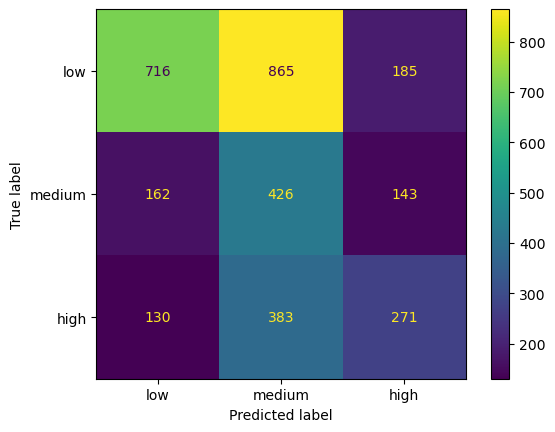

In [494]:
# Confusion matrix
cm = confusion_matrix(true_DI_cats, pred_DI_cats, labels = [0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['low', 'medium', 'high'])

disp.plot()
plt.show()

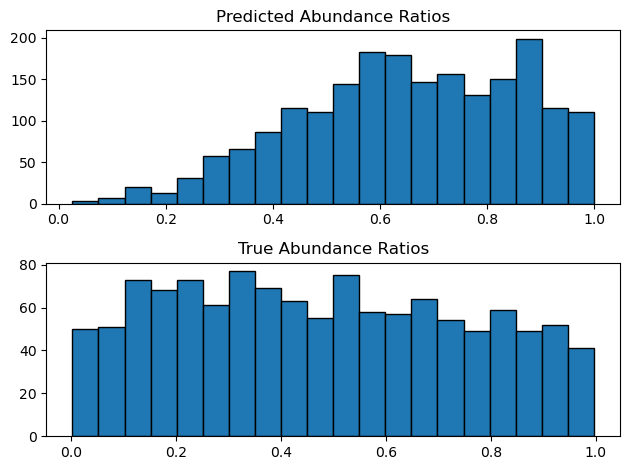

In [495]:
# Comparing the distribution of abundance ratios in the 0-1 range...
fig, ax = plt.subplots(2)

pred_ratios_0_1 = pred_ratios[(pred_ratios < 1) & (pred_ratios > 0)]
ax[0].hist(pred_ratios_0_1, edgecolor = 'black', bins = 20)
ax[0].set_title('Predicted Abundance Ratios')

true_ratios_0_1 = ratio[(ratio < 1) & (ratio > 0)]
ax[1].hist(true_ratios_0_1, edgecolor = 'black', bins = 20)
ax[1].set_title('True Abundance Ratios')

fig.tight_layout()

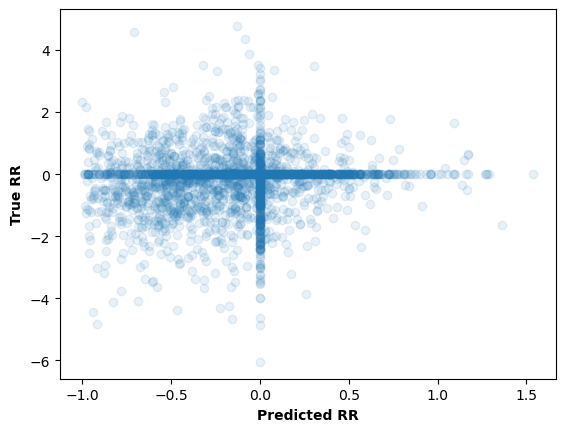

In [496]:
# Regression results, RR
threshold_mask = y_pred[ratio != 0] > -1

rr_true = np.log(ratio[ratio != 0])[threshold_mask]
rr_pred = y_pred[ratio != 0][threshold_mask]

plt.scatter(rr_pred, rr_true, alpha = 0.1)

plt.xlabel('Predicted RR', weight = 'bold')
plt.ylabel('True RR', weight = 'bold');

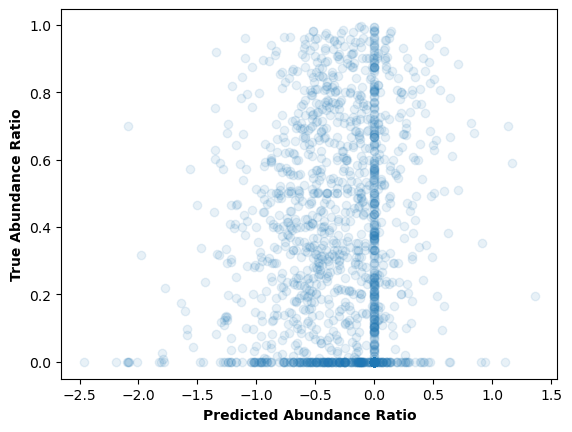

In [498]:
# Regression results, abundance ratio
threshold_mask = ratio < 1

plt.scatter(y_pred[threshold_mask], ratio[threshold_mask], alpha = 0.1)

plt.xlabel('Predicted Abundance Ratio', weight = 'bold')
plt.ylabel('True Abundance Ratio', weight = 'bold');

## Fitting the model using `statsmodels`

Documentation:
- [MixedLM](https://www.statsmodels.org/devel/generated/statsmodels.regression.mixed_linear_model.MixedLM.html)
   - [Usage and comparison to `lme4` in R](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html)
- [BinomialBayesMixedGLM](https://www.statsmodels.org/stable/generated/statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM.html#statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM)

In [215]:
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

In [210]:
ben_lop2019.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


In [225]:
# Extracting the needed data
nonzero_me = ben_lop2019[['BM', 'DistKm', 'PopDens', 'Country', 'Study', 'Species']].copy(deep = True)
nonzero_me['DistKm^2'] = nonzero_me['DistKm'] ** 2
nonzero_me['PopDens^2'] = nonzero_me['PopDens'] ** 2
nonzero_me['BMxDistKm'] = nonzero_me['BM'] * nonzero_me['DistKm']

#  making sure to only grab the nonzero RR values
nonzero_mask = ben_lop2019['ratio'] != 0
nonzero_me_target = ben_lop2019['RR'][nonzero_mask]
nonzero_me = nonzero_me[nonzero_mask]

# Defining variables for fixed and random effects
random_effects = ['Country', 'Study', 'Species']
fixed_effects = list(set(nonzero_me.columns) - set(random_effects)) # everything else...
nonzero_re = nonzero_me[random_effects].copy(deep = True)
nonzero_fe = nonzero_me[fixed_effects].copy(deep = True)

In [227]:
# Specifying the mixed effect Gaussian model
mlm = MixedLM(endog = nonzero_me_target, exog = nonzero_fe, exog_re = nonzero_re, groups = None)

TypeError: 'NoneType' object is not iterable

## Previous stuff...

In [14]:
# Defining the two models
nonzero_model = LinearRegression()
zero_model = LogisticRegression(penalty = None)

# Fitting the models to ALL data
nonzero_model.fit(X_nonzero, y_nonzero)
zero_model.fit(X_zero, y_zero);

In [15]:
# Checking predictive accuracy
zero_pred = zero_model.predict(X_zero)
acc = np.mean(zero_pred == y_zero) * 100
print(f'Prob of extirpation model accuracy: {round(acc, 2)}%')

nonzero_pred = nonzero_model.predict(X_nonzero)
nonzero_pred_ratio = np.exp(nonzero_pred)
y_ratio = ben_lop2019['ratio'].values[zero_mask]
med_ae = np.median(np.abs(nonzero_pred_ratio - y_ratio))
print(f'Nonzero RR model median absolute error: {round(med_ae, 2)}')

Prob of extirpation model accuracy: 87.56%
Nonzero RR model median absolute error: 0.25


In [27]:
# Tuning probability treshold for extirpation classification using the True Skill Statistic
y_prob = zero_model.predict_proba(X_zero)[ : , 1]
thresholds = np.linspace(0, 1, 1000)

perf = []
for thresh in thresholds:
    y_pred = (y_prob >= thresh).astype(int)
    tss = recall_score(y_zero, y_pred, pos_label = 1) + recall_score(y_zero, y_pred, pos_label = 0) - 1
    perf.append(tss)

In [31]:
thresholds[np.argmax(perf)], np.max(perf)

(0.13213213213213212, 0.3561608075182736)

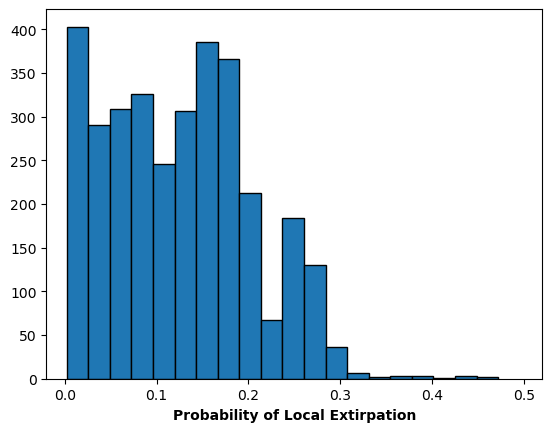

In [16]:
# Taking a look at classification results
plt.hist(zero_model.predict_proba(X_zero)[ : , 1], bins = 20, edgecolor = 'black')

plt.xlim(-0.02, 0.52)
plt.xlabel('Probability of Local Extirpation', weight = 'bold');

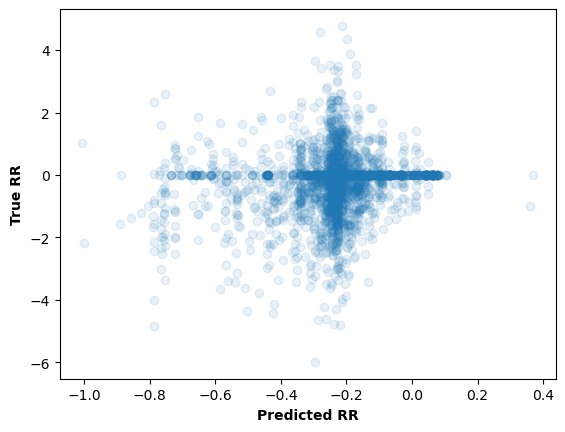

In [17]:
# Regression results, RR
plt.scatter(nonzero_pred, y_nonzero, alpha = 0.1)

plt.xlabel('Predicted RR', weight = 'bold')
plt.ylabel('True RR', weight = 'bold');

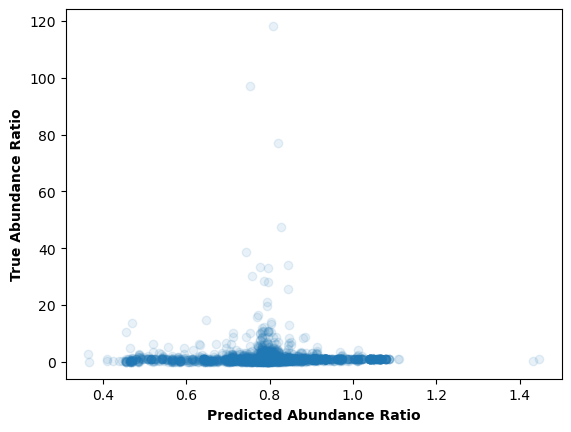

In [18]:
# Regression results, abundance ratio
plt.scatter(nonzero_pred_ratio, y_ratio, alpha = 0.1)

plt.xlabel('Predicted Abundance Ratio', weight = 'bold')
plt.ylabel('True Abundance Ratio', weight = 'bold');